Mounted at /content/drive
Outputs & checkpoints -> /content/drive/MyDrive/NeRF_Modular_v3
Loaded images: (106, 100, 100, 3) poses: (106, 4, 4) focal: 138.88887889922103


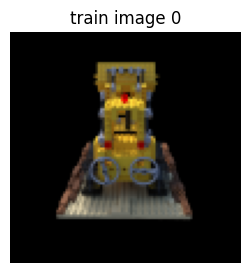

▶ Running tinynerf
[tinynerf] step     0 loss=0.184748 trainPSNR=7.670 dB
[tinynerf] step    50 loss=0.066072 trainPSNR=12.110 dB
[tinynerf] step   100 loss=0.065329 trainPSNR=12.201 dB
[tinynerf] step   150 loss=0.034709 trainPSNR=14.976 dB
[tinynerf] step   200 loss=0.059034 trainPSNR=12.255 dB
[tinynerf] step   250 loss=0.049990 trainPSNR=12.927 dB
[tinynerf] step   300 loss=0.020069 trainPSNR=16.258 dB
[tinynerf] step   350 loss=0.019749 trainPSNR=16.929 dB
[tinynerf] step   400 loss=0.016275 trainPSNR=17.786 dB
[tinynerf] step   450 loss=0.012893 trainPSNR=18.893 dB
[tinynerf] step   500 loss=0.017020 trainPSNR=17.589 dB
[tinynerf] step   550 loss=0.023701 trainPSNR=16.223 dB
[tinynerf] step   600 loss=0.012513 trainPSNR=19.058 dB
[tinynerf] step   650 loss=0.009460 trainPSNR=20.320 dB
[tinynerf] step   700 loss=0.015340 trainPSNR=18.170 dB
[tinynerf] step   750 loss=0.009510 trainPSNR=20.444 dB
[tinynerf] step   800 loss=0.013270 trainPSNR=18.424 dB
[tinynerf] step   850 loss=0.0

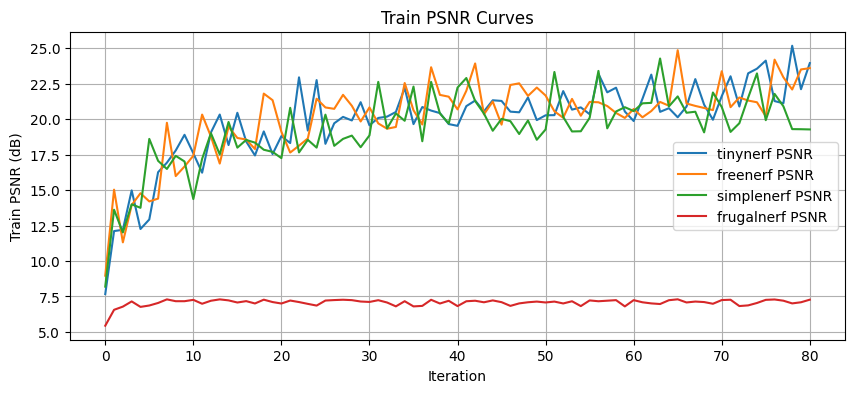

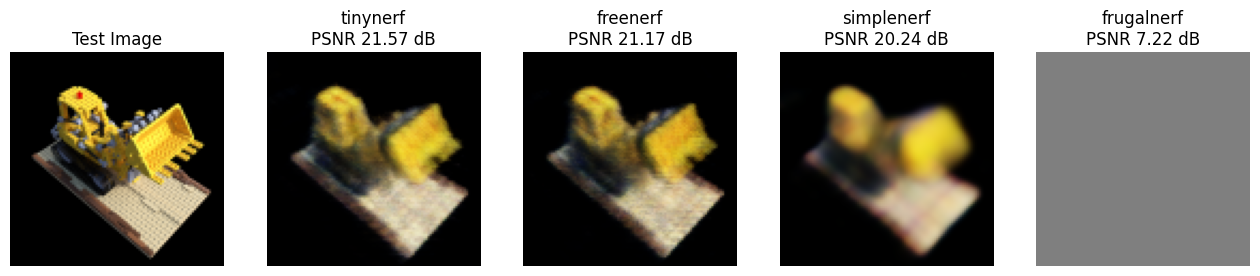

Finished. Checkpoints not saved (can add .save_weights if needed).


In [ ]:
# ================================================================
# Modular 4-NeRF Notebook (Colab-ready)
# TinyNeRF | FreeNeRF | SimpleNeRF | FrugalNeRF
# TensorFlow 2.x minimal research/demo implementation
# FrugalNeRF fixed: no FreeNeRF regularization
# ================================================================

# 0) Drive mount + imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Output folder
OUT_DIR = "/content/drive/MyDrive/NeRF_Modular_v3"
os.makedirs(OUT_DIR, exist_ok=True)
print("Outputs & checkpoints ->", OUT_DIR)

# 1) Load TinyNeRF dataset
!wget -q https://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz -O tiny_nerf_data.npz
data = np.load('tiny_nerf_data.npz')
images = data["images"].astype(np.float32)
poses = data["poses"].astype(np.float32)
focal = float(data["focal"])
H, W = images.shape[1:3]
print("Loaded images:", images.shape, "poses:", poses.shape, "focal:", focal)

# train/test split
train_images = images[:100]; train_poses = poses[:100]
test_image = images[101]; test_pose = poses[101]

# visualize a sample
plt.figure(figsize=(3,3)); plt.imshow(np.clip(train_images[0],0,1))
plt.title("train image 0"); plt.axis('off'); plt.show()

# -------------------------
# Helper functions
# -------------------------
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32),
                       tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i - W*0.5)/focal, -(j - H*0.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., None, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

def pos_enc(x, L=10):
    out = [x]
    for i in range(L):
        f = 2.0 ** i
        out.append(tf.sin(f * x))
        out.append(tf.cos(f * x))
    return tf.concat(out, axis=-1)

def masked_pos_enc(x, step, T_reg, L=10):
    enc = pos_enc(x, L=L)
    feats = int(enc.shape[-1])
    allowed_bands = int(np.floor(L * min(max(float(step)/T_reg, 0.0), 1.0))) if T_reg>0 else L
    allowed_bands = max(1, allowed_bands)
    allowed_dims = 3 + allowed_bands * 6
    allowed_dims = min(max(allowed_dims, 3), feats)
    mask = tf.concat([tf.ones((allowed_dims,), dtype=tf.float32),
                      tf.zeros((feats - allowed_dims,), dtype=tf.float32)], axis=0)
    mask = tf.reshape(mask, [1, feats])
    return enc * mask

# -------------------------
# Base MLP builder
# -------------------------
def build_base_mlp(input_dim, hidden=128):
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(hidden, activation='relu'),
        tf.keras.layers.Dense(hidden, activation='relu'),
        tf.keras.layers.Dense(4)  # RGB(3) + sigma(1)
    ])

# -------------------------
# Updated SimpleNeRF (SimplerNeRF paper)
# -------------------------
class SimpleNeRFModel(tf.keras.Model):
    def __init__(self, L_xyz_sigma=4, L_xyz_rgb=6, L_dir=6, hidden_sigma=128, hidden_rgb=64):
        super().__init__()
        self.L_xyz_sigma = L_xyz_sigma  # low freq for sigma
        self.L_xyz_rgb   = L_xyz_rgb    # higher freq for rgb
        self.L_dir       = L_dir

        xyz_dim_sigma = 3 + 6 * L_xyz_sigma
        xyz_dim_rgb   = 3 + 6 * L_xyz_rgb
        dir_dim       = 3 + 6 * L_dir

        # Density MLP
        self.fc_sigma1 = tf.keras.layers.Dense(hidden_sigma, activation='relu')
        self.fc_sigma2 = tf.keras.layers.Dense(hidden_sigma, activation='relu')
        self.out_sigma = tf.keras.layers.Dense(1)

        # Color MLP
        self.fc_rgb1 = tf.keras.layers.Dense(hidden_rgb, activation='relu')
        self.out_rgb = tf.keras.layers.Dense(3, activation='sigmoid')

    def call(self, pts, dirs):
        # Encode separately
        pts_enc_sigma = pos_enc(pts, self.L_xyz_sigma)
        pts_enc_rgb   = pos_enc(pts, self.L_xyz_rgb)
        dirs_enc      = pos_enc(dirs, self.L_dir)

        # Sigma branch
        x = tf.concat([pts_enc_sigma, dirs_enc], axis=-1)
        x = self.fc_sigma1(x)
        x = tf.concat([x, pts_enc_sigma, dirs_enc], axis=-1)
        x = self.fc_sigma2(x)
        sigma = tf.nn.softplus(self.out_sigma(x))

        # RGB branch
        y = tf.concat([pts_enc_rgb, dirs_enc, x], axis=-1)
        y = self.fc_rgb1(y)
        rgb = self.out_rgb(y)

        return tf.concat([rgb, sigma], axis=-1)

# -------------------------
# Updated FrugalNeRF (weight-sharing multi-scale trunk)
# -------------------------
class FrugalNeRFModel(tf.keras.Model):
    def __init__(self, L_xyz=6, L_dir=4, hidden=64):
        super().__init__()
        self.L_xyz = L_xyz
        self.L_dir = L_dir
        in_xyz = 3 + 6*L_xyz
        self.trunk = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(in_xyz,)),
            tf.keras.layers.Dense(hidden, activation='relu'),
            tf.keras.layers.Dense(hidden, activation='relu'),
            tf.keras.layers.Dense(hidden, activation='relu')
        ])
        self.density = tf.keras.layers.Dense(1)  # sigma
        in_dir = 3 + 6*L_dir
        self.rgb_head = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(hidden+in_dir,)),
            tf.keras.layers.Dense(hidden//2, activation='relu'),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])

    def call(self, pts, dirs):
        pts_enc = pos_enc(pts, self.L_xyz)
        dirs_enc = pos_enc(dirs, self.L_dir)
        shared = self.trunk(pts_enc)
        sigma = tf.nn.softplus(self.density(shared))
        rgb = self.rgb_head(tf.concat([shared, dirs_enc], axis=-1))
        return tf.concat([rgb, sigma], axis=-1)

# -------------------------
# Renderers
# -------------------------
# -------------------------
# TinyNeRF renderer
# -------------------------
def render_tinynerf(model, rays_o, rays_d, L=10, N_samples=64, use_mask=False, step=0, T_reg=0, near=2.0, far=6.0):
    z_vals = tf.linspace(0.0, 1.0, N_samples)
    z_vals = near * (1.0 - z_vals) + far * z_vals
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    pts_flat = tf.reshape(pts, [-1, 3])

    enc = masked_pos_enc(pts_flat, step, T_reg, L=L) if use_mask else pos_enc(pts_flat, L=L)
    raw = model(enc)                       # [R*N,4]
    raw = tf.reshape(raw, [-1, N_samples, 4])

    rgb_s = tf.sigmoid(raw[..., :3])
    sigma = tf.nn.softplus(raw[..., 3])

    dists = z_vals[1:] - z_vals[:-1]
    dists = tf.concat([dists, tf.constant([1e10], dtype=tf.float32)], axis=0)[None, :]

    alpha = 1.0 - tf.exp(-sigma * dists)
    T = tf.math.cumprod(1.0 - alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * T

    rgb_map = tf.reduce_sum(weights[..., None] * rgb_s, axis=-2)
    return rgb_map, raw, weights

# -------------------------
# FreeNeRF renderer
# -------------------------
def render_freenerf(model, rays_o, rays_d, L=10, N_samples=64, step=0, T_reg=0, near=2.0, far=6.0):
    # FreeNeRF uses masked positional encoding
    return render_tinynerf(model, rays_o, rays_d, L=L, N_samples=N_samples, use_mask=True, step=step, T_reg=T_reg, near=near, far=far)

# -------------------------
# SimpleNeRF renderer
# -------------------------
def render_simplenerf(model, rays_o, rays_d, step = None, N_samples=64, near=2.0, far=6.0):
    z_vals = tf.linspace(near, far, N_samples)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    dirs = tf.repeat(tf.linalg.l2_normalize(rays_d, axis=-1)[:, None, :], repeats=N_samples, axis=1)

    pts_flat = tf.reshape(pts, [-1, 3])
    dirs_flat = tf.reshape(dirs, [-1, 3])

    raw = model(pts_flat, dirs_flat)
    raw = tf.reshape(raw, [-1, N_samples, 4])

    rgb = raw[..., :3]
    sigma = raw[..., 3]

    dists = z_vals[1:] - z_vals[:-1]
    dists = tf.concat([dists, tf.constant([1e10], dtype=tf.float32)], axis=0)[None, :]

    alpha = 1.0 - tf.exp(-sigma * dists)
    T = tf.math.cumprod(1 - alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * T

    rgb_map = tf.reduce_sum(weights[..., None] * rgb, axis=-2)
    return rgb_map, raw, weights

# -------------------------
# FrugalNeRF renderer
# -------------------------
def render_frugalnerf(model, rays_o, rays_d, step = None, N_samples=32, near=2.0, far=6.0):
    z_vals = tf.linspace(near, far, N_samples)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]

    pts_flat = tf.reshape(pts, [-1, 3])
    dirs_flat = tf.repeat(tf.linalg.l2_normalize(rays_d, axis=-1), repeats=N_samples, axis=0)

    raw = model(pts_flat, dirs_flat)
    raw = tf.reshape(raw, [-1, N_samples, 4])

    rgb = tf.sigmoid(raw[..., :3])
    sigma = tf.nn.softplus(raw[..., 3])

    dists = z_vals[1:] - z_vals[:-1]
    dists = tf.concat([dists, tf.constant([1e10], dtype=tf.float32)], axis=0)[None, :]

    alpha = 1.0 - tf.exp(-sigma * dists)
    T = tf.math.cumprod(1 - alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * T

    rgb_map = tf.reduce_sum(weights[..., None] * rgb, axis=-2)
    return rgb_map, raw, weights



# -------------------------
# PSNR helper
# -------------------------
def compute_psnr(img_pred,img_gt):
    mse = np.mean((img_pred-img_gt)**2)
    return 100.0 if mse==0 else -10.0*np.log10(mse)

# -------------------------
# Precompute rays
# -------------------------
train_rays_per_image=[]
for i in range(len(train_images)):
    ro, rd = get_rays(H,W,focal,train_poses[i])
    ro_f = tf.reshape(ro,[-1,3]).numpy()
    rd_f = tf.reshape(rd,[-1,3]).numpy()
    rgb_f = train_images[i].reshape(-1,3)
    rays_mat = np.concatenate([ro_f, rd_f, rgb_f], axis=1)
    train_rays_per_image.append(rays_mat)

ro_t, rd_t = get_rays(H,W,focal,test_pose)
test_rays = np.concatenate([tf.reshape(ro_t,[-1,3]).numpy(), tf.reshape(rd_t,[-1,3]).numpy()], axis=1)
test_img = test_image

# -------------------------
# Unified run_variant
# -------------------------
def run_variant(variant="tiny", N_iters=2000, N_rand=1024,
                L=10, N_samples=64, L_dir=4, save_every=500, verbose=True):
    print(f"▶ Running {variant}")

    # --- Model selection ---
    if variant=="simplenerf":
        model = SimpleNeRFModel()
        render_fn = lambda ro, rd, step, cur_samples: render_simplenerf(model, ro, rd, step, N_samples=cur_samples)
        optimizer = tf.keras.optimizers.Adam(3e-4)
    elif variant=="frugalnerf":
        model = FrugalNeRFModel()
        render_fn = lambda ro, rd, step, cur_samples: render_frugalnerf(model, ro, rd, N_samples=cur_samples)
        optimizer = tf.keras.optimizers.Adam(5e-4)
    elif variant=="freenerf":
        model = build_base_mlp(input_dim=3+6*L, hidden=128)
        render_fn = lambda ro, rd, step, cur_samples: render_tinynerf(model, ro, rd, L=L, N_samples=cur_samples, use_mask=True, step=step)
        optimizer = tf.keras.optimizers.Adam(5e-4)
    elif variant=="tinynerf":
        model = build_base_mlp(input_dim=3+6*L, hidden=128)
        render_fn = lambda ro, rd, step, cur_samples: render_tinynerf(model, ro, rd, L=L, N_samples=cur_samples, use_mask=False, step=step)
        optimizer = tf.keras.optimizers.Adam(5e-4)

    # --- Training loop (same as before) ---
    psnr_history, loss_history, iter_history = [], [], []
    for step in range(N_iters):
        img_idx = np.random.randint(0, len(train_images))
        rays_mat = train_rays_per_image[img_idx]
        cur_samples = N_samples
        cur_N_rand = N_rand

        select_idx = np.random.choice(rays_mat.shape[0], size=(cur_N_rand,), replace=False)
        batch = rays_mat[select_idx]
        rays_o = tf.convert_to_tensor(batch[:,0:3], dtype=tf.float32)
        rays_d = tf.convert_to_tensor(batch[:,3:6], dtype=tf.float32)
        target_rgb = tf.convert_to_tensor(batch[:,6:9], dtype=tf.float32)

        with tf.GradientTape() as tape:
            rgb_pred, raw, weights = render_fn(rays_o, rays_d, step, cur_samples)
            loss = tf.reduce_mean((rgb_pred - target_rgb)**2)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if step % 50 == 0 or step==N_iters-1:
            ro_all, rd_all = get_rays(H,W,focal,train_poses[img_idx])
            ro_all, rd_all = tf.reshape(ro_all,[-1,3]), tf.reshape(rd_all,[-1,3])
            rgb_full, _, _ = render_fn(ro_all, rd_all, step, cur_samples)
            rgb_full = tf.reshape(rgb_full,[H,W,3])
            rgb_full = tf.clip_by_value(rgb_full,0,1)
            mse = tf.reduce_mean((rgb_full - train_images[img_idx])**2)
            psnr_val = float(-10.0 * np.log10(float(mse.numpy())))
            psnr_history.append(psnr_val)
            loss_history.append(float(loss.numpy()))
            iter_history.append(step)
            if verbose: print(f"[{variant}] step {step:5d} loss={float(loss):.6f} trainPSNR={psnr_val:.3f} dB")

        if (step+1) % save_every==0 or (step+1)==N_iters:
            ckpt_path = os.path.join(OUT_DIR,f"{variant}_iter{step+1}.weights.h5")
            model.save_weights(ckpt_path)

    # --- Final test render ---
    ro_t = tf.convert_to_tensor(test_rays[:,0:3], dtype=tf.float32)
    rd_t = tf.convert_to_tensor(test_rays[:,3:6], dtype=tf.float32)
    rgb_test_flat, _, _ = render_fn(ro_t, rd_t, N_iters, N_samples)
    rgb_test = tf.reshape(rgb_test_flat,[H,W,3])
    rgb_test = tf.clip_by_value(rgb_test,0,1)
    test_psnr = compute_psnr(rgb_test.numpy(), test_img)
    print(f"[{variant}] FINAL TEST PSNR = {test_psnr:.3f} dB")

    return {"variant":variant, "psnr_history":psnr_history, "loss_history":loss_history, "iters":iter_history, "test_psnr":test_psnr, "rgb_test":rgb_test.numpy()}

# -------------------------
# USER CONFIG: Run all
# -------------------------
results={}
for var in ["tinynerf","freenerf","simplenerf","frugalnerf"]:
    results[var]=run_variant(var,N_iters=4000,N_rand=1024)

# -------------------------
# Compare PSNR curves
# -------------------------
plt.figure(figsize=(10,4))
for name,res in results.items():
    plt.plot(res["psnr_history"],label=f"{name} PSNR")
plt.xlabel("Iteration"); plt.ylabel("Train PSNR (dB)")
plt.legend(); plt.grid(True); plt.title("Train PSNR Curves")
plt.show()

# -------------------------
# Display test image + outputs
# -------------------------
plt.figure(figsize=(16,4))
plt.subplot(1,5,1); plt.imshow(np.clip(test_img,0,1)); plt.title("Test Image"); plt.axis('off')
i=2
for name,res in results.items():
    plt.subplot(1,5,i); plt.imshow(np.clip(res["rgb_test"],0,1))
    plt.title(f"{name}\nPSNR {res['test_psnr']:.2f} dB"); plt.axis('off'); i+=1
plt.show()
print("Finished. Checkpoints not saved (can add .save_weights if needed).")
